## HOMEWORK 4
## 1) Does basic house information reflect house's description?

In this part of the homework our task is to perform a clustering analysis of house announcements in Rome from Immobiliare.it. We will create two datasets by retrieving data from websites. Then, we will
implement two clustering methods and compare the results. In order to use the best number of clusters per dataset we use Elbow method.

**Python Libraries and Settings:**

In [6]:
import time
import threading
import requests
from bs4 import BeautifulSoup
import re
import csv
import pandas as pd
import numpy as np

# for the clustering part:
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# for hiding warnings
import warnings
warnings.filterwarnings('ignore')

# our external module:
import collect_data
import functions

## **Scraping data**

### *  Collecting links

As the first step, we are collecting the list of interesting urls, starting from the website:
https://www.immobiliare.it/vendita-case/roma/?criterio=rilevanza&pag=1.

+ We are using the time.sleep function to prevent the websie blocking.
+ The implementation of "thread_find_links" function is located in the external file **collect_data.py**

In [ ]:
link_threads = []
for nr_page in range(1, 100):
    # collect all urls from the given page
    t = threading.Thread(target=collect_data.thread_find_links, args=("nr_page",))
    t.start()
    time.sleep(1)

In [64]:
print("The number of collected links: {}".format(len(link_threads)))

The number of collected links: 25974


+ We are saving collected links into **links.txt** file

In [1]:
with open("links.txt", "w") as link_file:
    for url_ in link_threads:
        link_file.write(url_)

Reading "links.txt" file : 

In [8]:
# Load data from link.txt 
with open("links.txt", "r") as link_file:
    link_threads = link_file.readlines()

### * Collecting data

+ Now, we are iterating through all collected links in order to retrieve and save data about flats. 
+ For this, we defined the fuction **threadExtract**. We applied the parallel programming by generating threads for each url. 

In [27]:
def threadExtract(url):
    """
    This function gets html content and scraps the interesting data
    Input: String: "url" 
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    # use defined function for collecting data from websites
    scrapped_data = collect_data.scrap_data(soup)
    # if scrapped data is not empty, save it
    if scrapped_data != None:
        datawriter.writerow(scrapped_data)

+ The collected data about "price", "locali", "superficie", "bagni" and "desciption" are saved into **flat_data.txt** file.

In [33]:
# create and open file
data_file = open("flat_data.txt", "w", encoding='utf-8')
# column names:
headers = ["price", "locali", "superficie", "bagni", "piano", "description"]
datawriter = csv.writer(data_file)
# write headers
datawriter.writerow(headers)

49

In [2]:
failed_links = []

def create_threads(from_, to_):
    '''
    Function to create threads sequentially for links on positions between 'from_' and 'to_'
    '''
    for link_ in link_threads[from_ : to_]:
        # try collect data from the website
        try:
            threading.Thread(threadExtract(link_[:-1])).start() #-1 because we have "\n" in the end of a link
            time.sleep(3) #for non-blocking
        except Exception as e:
            print(e)
            failed_links.append(link_)

+ Running threads for previously collected links. Get links on positions between 'from_' and 'to_' 

In [3]:
for rep in range(0, 15000, 100):
    create_threads(from_= rep, to_ = rep+100)

data_file.close()

## Datasets
All collected data are saved in **flat_data.txt** file.

We are reading the **flat_data.txt** file content as dataframe.
Then, we are splitting the collected data into two separated datasets:
+ **Information dataset** : [price, locali, superficie, bagni, piano]
+ **Description dataset** : [TFIDF matrix for descriptions]

For **TFIDF matrix** we created a separated notebook. See: **TFIDF_matrix.ipynb**

In [7]:
data_frame = pd.read_csv("flat_data.txt")

In [4]:
data_frame.head()

,price,locali,superficie,bagni,piano,description
0,1260000,5,225,2,4,In stabile signorile in Via Appia Nuov...
1,245000,2,80,1,2,Rif: G118 - APPIA NUOVA STATUARIO Via ...
2,319000,3,114,1,1,proponiamo in vendiata ampio e luminos...
3,630000,4,153,2,5,Rif: 20141 - Appartamento composto da ...
4,157000,3,68,1,1,Proponiamo la vendita di un trilocale ...


In [4]:
print("We managed to collect data about {} announcements".format(len(data_frame)))

We managed to collect data about 10544 announcements


**Information dataset**

For Information Dataset we are reading only five columns : "price", "locali", "superficie", "bagni", "piano".

In [8]:
inf_dataset = data_frame[["price", "locali", "superficie", "bagni", "piano"]]
inf_dataset.head()

,price,locali,superficie,bagni,piano
0,1260000,5,225,2,4
1,245000,2,80,1,2
2,319000,3,114,1,1
3,630000,4,153,2,5
4,157000,3,68,1,1


**Description Dataset**

In order to create the TFIDF matrix (Description Dataset), we created the separated Jupyter Notebook **TFIDF_matrix**. After running the code there, the following files were generated:
+ vocabulary.txt -    contains information about all unique words and their "id"s
+ inverted_indx.txt - stores words and theirs locations in annoucements 
+ tfid.csv -   stores information about TFIDF scores

We are reading **vocabulary.txt** and **tfid.csv** using pre-defined **read_vocabulary** and **read_tfid** functions, which are located in our **functions** module.

In [43]:
vocabulary = functions.read_vocabulary(file = 'vocabulary.txt')

In [150]:
tfid = functions.read_tfid(file = 'tfid.csv')

The next step is creating the full **description_matrix**, where all rows correspond to announcements and columns to word_ids from descriptions.

We are putting data about **tfidf scores** into DataFrame. 

Words which do not exist in all annoucements (missing values) are replaced from NaN into 0.

In [3]:
dict_df = pd.DataFrame(columns=[i for i in range(len(vocabulary))])
# filling dataframe row by row :
for i in range(len(tfid)):
    dict_df = dict_df.append(tfid[i], ignore_index=True)

# change NaN values to 0.
dict_df = dict_df.fillna(0)

# name for the index column
dict_df.index.name = "Ann_index"
#description_data_frame.drop(columns = ["Ann_index"])
dict_df.head()

Saving **Descriptin Matrix** to the **description_matrix.csv** file for further analysis.

In [7]:
dict_df.to_csv("description_matrix.csv")

In [19]:
# READING
description_dataset = pd.read_csv("description_matrix.csv")

## Clustering

###  K-means++

This part consists of clustering the house announcements using K-means++ method. 
In order to choose the optimal number of clusters we used the Elbow-Method.

#### INFORMATION DATASET
1) Perform the Elbow-Method to choose the best number of clusters:

In [41]:
inf_dataset.head()

,price,locali,superficie,bagni,piano
0,1260000,5,225,2,4
1,245000,2,80,1,2
2,319000,3,114,1,1
3,630000,4,153,2,5
4,157000,3,68,1,1


In [44]:
# collecting scores from Elbow-method
inf_dataset_scores = {}
# iterating through different 'k' - number of clusters
for k in range(1,20):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(inf_dataset)
    inf_dataset_scores[k] = kmeanModel.inertia_ 

2) Plot results (inf_dataset_scores):
+ We are using previously defined funtion **plot_inertia** located in functions.py module

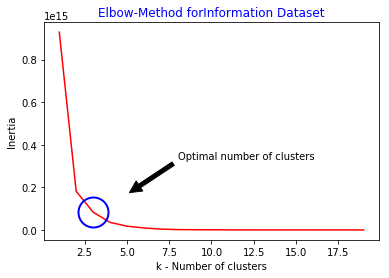

In [104]:
functions.plot_inertia(dataset_scores=inf_dataset_scores, info="Information Dataset")

3) Perform clustering for the best number of clusters. In this case for **nr_clusters = 3**

In [10]:
kmeanModel = KMeans(n_clusters=3).fit(inf_dataset)
inf_dataset['information_clusters'] = kmeanModel.labels_

Head of 'inf_dataset' with added column **information_clusters** :

In [30]:
inf_dataset.head()

,price,locali,superficie,bagni,piano,information_clusters
0,1260000,5,225,2,4,2
1,245000,2,80,1,2,0
2,319000,3,114,1,1,0
3,630000,4,153,2,5,1
4,157000,3,68,1,1,0


#### DESCRIPTION DATASET
1) Perform the Elbow-Method to choose the best number of clusters:


In [20]:
description_dataset.head()

,Ann_index,0,1,2,3,4,5,6,7,8,...,753,754,755,756,757,758,759,760,761,762
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,-0.0538,0.00000,0.0,0.0,0.00000
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.00000,0.0,0.0,0.00000
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.0538,...,0.0,0.0,0.0,0.0,0.0,0.0000,-0.04501,0.0,0.0,0.00000
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.04501,-0.0538,...,0.0,0.0,0.0,0.0,0.0,0.0000,0.00000,0.0,0.0,0.00000
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0,-0.0538,0.00000,0.0,0.0,-0.04501


In [21]:
description_dataset_scores = {}
for k in range(1,20):
    kmeanModel = KMeans(n_clusters=k, init='k-means++').fit(description_dataset)
    description_dataset_scores[k] = kmeanModel.inertia_

2) Plot results (description_dataset_scores):

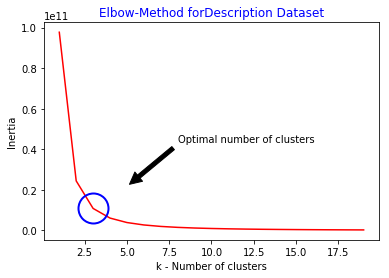

In [27]:
functions.plot_inertia(dataset_scores=description_dataset_scores, info="Description Dataset")

3) Perform clustering for the best number of clusters. In this case, for **nr_clusters = 3**

In [28]:
kmeanModel = KMeans(n_clusters=3).fit(description_dataset)
description_dataset['description_clusters'] = kmeanModel.labels_

Head of 'description_dataset' with added column **description_clusters** :

In [29]:
description_dataset.head()

,Ann_index,0,1,2,3,4,5,6,7,8,...,754,755,756,757,758,759,760,761,762,description_clusters
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,-0.0538,0.00000,0.0,0.0,0.00000,0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,0.0000,0.00000,0.0,0.0,0.00000,0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,-0.0538,...,0.0,0.0,0.0,0.0,0.0000,-0.04501,0.0,0.0,0.00000,0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.04501,-0.0538,...,0.0,0.0,0.0,0.0,0.0000,0.00000,0.0,0.0,0.00000,0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0000,...,0.0,0.0,0.0,0.0,-0.0538,0.00000,0.0,0.0,-0.04501,0


## Comparison among clusters - Jaccard Similarity
To check similarity between information clusters vs description clusters, we ars using the Jaccard-Similarity measure. Then, we are selecting the 3-most similar couples of clusters.

+ We calculate the **Jaccard_Similarity** values for sets $A$ and $B$ according to the formula:

$$Jaccard Similarity = {{|A \cap B|}\over{|A \cup B|}}$$

For that, we defined the **jaccard_similarity** function, which as an input takes two sets: set1, set2.

In [34]:
def jaccard_similarity(set1, set2):
    return round(len(set1.intersection(set2))/len(set1.union(set2)), 4)

+ Next, we are grouping both **INFORMATION** and **DESCRIPTION DATASETS** according to their clusters. 

**Information Dataset**

In [31]:
clusters = 3
groups_dict_ds1 = {}
# grouping
cluster_groups = inf_dataset.groupby(by = "information_clusters")
for cluster_ in range(clusters):
    # getting indexes per group
    groups_dict_ds1[cluster_] = set(cluster_groups.get_group(cluster_).index)

**Description Dataset**

In [32]:
clusters = 3
groups_dict_ds2 = {}
# grouping
cluster_groups = description_dataset.groupby(by = "description_clusters")
for cluster_ in range(clusters):
    # getting indexes per group
    groups_dict_ds2[cluster_] = set(cluster_groups.get_group(cluster_).index)

+ Calculating Jaccard Similarity for each couple of clusters from Information and Description Dataset:

In [35]:
jaccard_scores = sorted([(jaccard_similarity(clu1, clu2), nr1, nr2) for nr1, clu1 in groups_dict_ds1.items() for nr2, clu2 in groups_dict_ds2.items()])
# taking 3 couples with the best (the highest) Jaccard Similarity scores
best_3_couples = sorted(jaccard_scores[-3:])

In [36]:
print("TOP 3 COUPLES: \nInf_cluster | Desc_cluster| Jaccard_Similarity")
for i in best_3_couples:
    print(" {0:10} |  {1:10} | {2:18}".format(i[1], i[2], i[0]))

TOP 3 COUPLES: 
Inf_cluster | Desc_cluster| Jaccard_Similarity
          0 |           1 |              0.306
          0 |           0 |             0.3062
          0 |           2 |             0.3062


### **Wordclouds**

In [39]:
tfid = functions.read_tfid(file = 'tfid.csv')

+ Collecting words for each pair of the best clusters: 

We defined function **get_words_for_annoucements** (functions.py), which collect words from all annoucements given in the input as a list.

In [44]:
wordcloud_texts = []

for i in range(3):
    jacc_score, inf_cluster, desc_cluster = best_3_couples[i]
    
    # get list of all annoucements for Information Dataset cluster
    annoucs_list_1 = list(groups_dict_ds1[inf_cluster])
    # get all annoucements for Description Dataset cluster
    annoucs_list_2 = list(groups_dict_ds2[desc_cluster])
    
    # collect all words for both lists
    words_list_1 = functions.get_words_for_annoucements(tfid, annoucs_list_1)
    words_list_2 = functions.get_words_for_annoucements(tfid, annoucs_list_2)
    
    # join both lists as one big string/text and add text to the list 'wordcloud_texts' 
    wordcloud_texts.append(" ".join(words_list_1 + words_list_1))

+ Generating wordclouds for each couple of clusters:

In [47]:
# set figure size 
plt.rcParams["figure.figsize"] = [16,9]

#### Wordcloud for clusters:
+ Information Dataset - cluster 0
+ Description Dataset - cluster 1

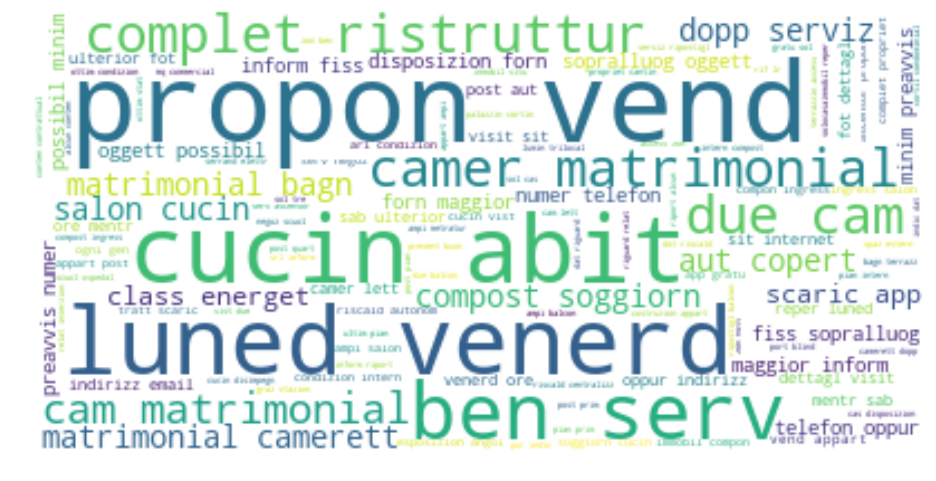

In [48]:
functions.generate_wordcloud(text = wordcloud_texts[0], name = "First_wordcloud")

**Wordcloud for clusters:**
+ Information Dataset - cluster 0
+ Description Dataset - cluster 0

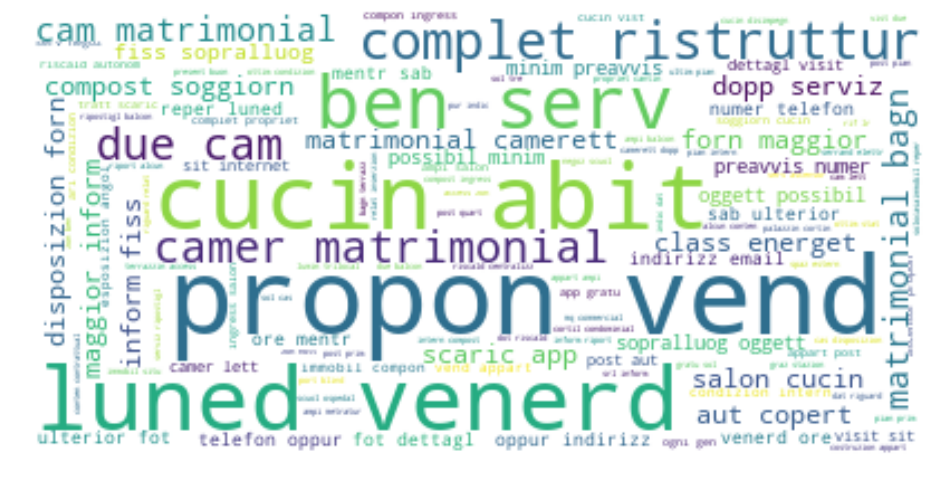

In [49]:
functions.generate_wordcloud(text = wordcloud_texts[1], name = "Second_wordcloud")

**Wordcloud for clusters:**
+ Information Dataset - cluster 0
+ Description Dataset - cluster 2

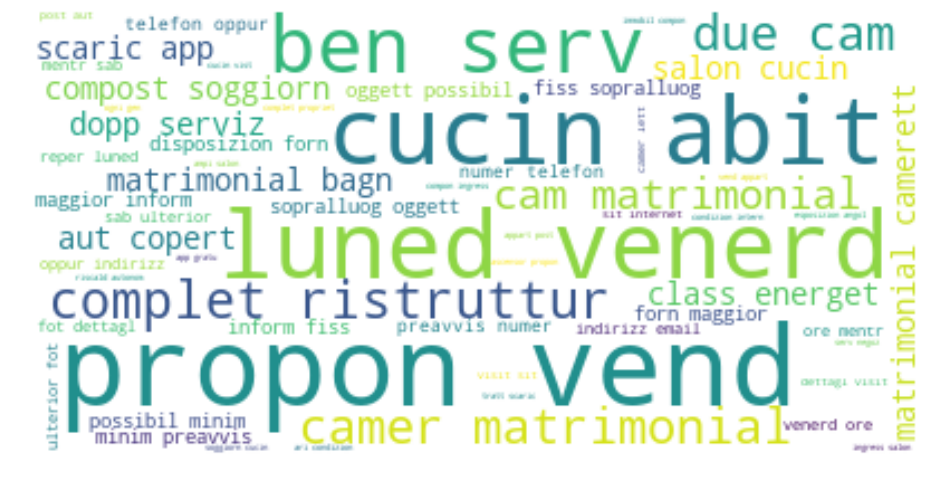

In [50]:
functions.generate_wordcloud(text = wordcloud_texts[2], name = "Third_wordcloud")

**We can see that words in wordclouds for each couple of clusters are similar. As we expected, both datasets lead to similar clusters.**